In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[2.3178e-07, 3.5027e-06, 9.9485e-01, 6.1043e-10, 2.2435e-07, 9.0086e-13,
          7.5602e-06, 3.7042e-08, 5.0100e-03, 1.3342e-04]]),
 tensor([[0.0257, 0.0442, 0.5447, 0.0078, 0.0255, 0.0021, 0.0516, 0.0178, 0.1890,
          0.0915]]),
 tensor([[0.0641, 0.0841, 0.2951, 0.0354, 0.0639, 0.0184, 0.0908, 0.0533, 0.1739,
          0.1210]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

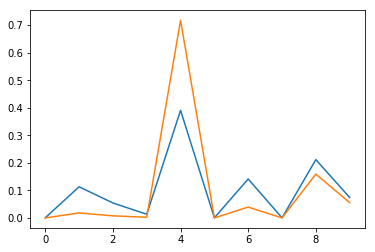

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

## Minimise width

with torch.no_grad():
    u,d = [],[]
    b = x[m]
    b[:,0] += 0.2
    u.append(to_shape(net(b)))
    b[:,0] -= 0.2
    b[:,2] *= 3.5/3
    u.append(to_shape(net(b)))
    b[:,2] /= 3.5/3
    b[:,0] -= 0.2
    d.append(to_shape(net(b)))
    b[:,0] += 0.2
    b[:,2] *= 2.5/3
    d.append(to_shape(net(b)))
    b[:,2] /= 2.5/3
    b_up,b_dw = torch.stack(u),torch.stack(d)

nll,alpha = calc_profile(f_s=f_s, f_b_nom=f_b, f_b_up=b_up, f_b_dw=b_dw, verbose=False, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

nll

plot_likelihood(to_np(nll-nll[nll==nll].min()))

nll = nll-nll[nll==nll].min()-0.5

nll

plot_likelihood(to_np(nll))

nll.max()-nll.min()

def get_diff_width(nll:Tensor, mu_scan:np.ndarray) -> Tensor:
    def lin_root(nll0,nll1,mu0,mu1):
        a = (nll1-nll0)/(mu1-mu0)
        b = nll1-(a*mu1)
        return -b/a
    
    u,r,last_mu,last_nll = True,torch.zeros((2)),mu_scan[0],nll[0]

    for mu,l in zip(mu_scan[1:],nll[1:]):
        if u and l < 0:
            r[0] = lin_root(last_nll,l,last_mu,mu)
            u = False
        elif not u and l > 0:
            r[1] = lin_root(last_nll,l,last_mu,mu)
            break
        if l == l: last_mu,last_nll = mu,l
    return r[1]-r[0]

w = get_diff_width(nll, mu_scan=np.linspace(20,80,61)); w

class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:int, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        r'''
        Fake loss function, callback computes loss in `on_forwards_end`
        '''
        self.wrapper.loss_func = lambda x,y: None
        self.profiler = partialler(calc_profile, n=self.n, mu_scan=to_device(self.mu_scan, self.wrapper.device), true_mu=self.true_mu,
                                   n_steps=self.n_steps, lr=self.lr, verbose=False)
        
    @staticmethod
    def _to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)
        f = f + 1e-7
        f = f/f.sum()
        return f
    
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
        
    def _get_diff_width(self, nll:Tensor) -> Tensor:
        def lin_root(nll0,nll1,mu0,mu1):
            a = (nll1-nll0)/(mu1-mu0)
            b = nll1-(a*mu1)
            return -b/a

        u,r,last_mu,last_nll = True,torch.zeros((2)),self.mu_scan[0],nll[0]
        for mu,l in zip(self.mu_scan[1:],nll[1:]):
            if u and l < 0:
                r[0] = lin_root(last_nll,l,last_mu,mu)
                u = False
            elif not u and l > 0:
                r[1] = lin_root(last_nll,l,last_mu,mu)
                break
            if l == l: last_mu,last_nll = mu,l
        return r[1]-r[0]
        
    def on_forwards_end(self) -> None:
        # Get sig. & bkg. shapes
        b = self.wrapper.y.squeeze()==0
        f_s = self._to_shape(self.wrapper.y_pred[~b])
        f_b = self._to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        
        # Compute nll
        nll,_ = self.profiler(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)
        try: nll = nll-nll[nll==nll].min()-0.5
        except RuntimeError: print(nll, self.wrapper.y_pred)
        w = self._get_diff_width(nll)
        print(w)
        print(self.wrapper.model[4].weight)
        self.wrapper.loss_val = torch.clamp_min(w, 0)

class PaperInferno(AbsInferno):
    def __init__(self, n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, n_steps:int=100, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, n_steps=n_steps, lr=lr)
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        with torch.no_grad():
            u,d = [],[]
            x[:,0] += 0.2
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] -= 0.2
            x[:,2] *= 3.5/3
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 3.5/3
            x[:,0] -= 0.2
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] += 0.2
            x[:,2] *= 2.5/3
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 2.5/3
            return torch.stack(u),torch.stack(d)

net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=nn.BCELoss(),
          cbs=[PaperInferno(),LossTracker(),EarlyStopping(5),GradClip(1e-5)])

model.save('weights/Inferno_Test.h5')

In [14]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:float, aug_alpha:bool=False, n_alphas:int=0, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
    
    @staticmethod
    def to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
        
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
    
    def get_ikk(self, f_s:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor) -> Tensor:       
        if self.aug_alpha: alpha = torch.randn((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        else:              alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad():
            alpha /= 10
            alpha[0] += self.true_mu
        get_nll = partialler(calc_nll, s_true=self.true_mu, b_true=self.n-self.true_mu,
                             f_s=f_s, f_b_nom=f_b_nom[None,:], f_b_up=f_b_up, f_b_dw=f_b_dw)
        if self.aug_alpha:  # Alphas carry noise, optimise via Newton
            for i in range(self.n_steps):  # Newton optimise nuisances & mu
                nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
                g,h = calc_grad_hesse(nll, alpha)
                s = torch.clamp(self.lr*g.detach()@torch.inverse(h), -100, 100)
                alpha = alpha-s
        nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
        return ikk
        
    def on_forwards_end(self) -> None:
        
    
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        self.wrapper.loss_val = self.get_ikk(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)

In [15]:
class PaperInferno(AbsInferno):
    def __init__(self, r_mods:Optional[Tuple[float,float]]=(-0.2,0.2), l_mods:Optional[Tuple[float,float]]=(2.5,3.5), l_init:float=3,
                 n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, aug_alpha:bool=False, n_steps:int=10, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, aug_alpha=aug_alpha, n_alphas=(r_mods is not None)+(l_mods is not None), n_steps=n_steps, lr=lr)
        self.r_mods,self.l_mods,self.l_init = r_mods,l_mods,l_init
        
    def on_train_begin(self) -> None:
        if self.r_mods is not None:
            self.r_mod_t = (torch.zeros(1,3, device=self.wrapper.device),torch.zeros(1,3, device=self.wrapper.device))
            self.r_mod_t[0][0,0] = self.r_mods[0]
            self.r_mod_t[1][0,0] = self.r_mods[1]
        if self.l_mods is not None:
            self.l_mod_t = (torch.ones(1,3, device=self.wrapper.device),torch.ones(1,3, device=self.wrapper.device))
            self.l_mod_t[0][0,2] = self.l_mods[0]/self.l_init
            self.l_mod_t[1][0,2] = self.l_mods[1]/self.l_init
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        if self.r_mods is None and self.l_mods is None: return None,None
        u,d = [],[]
        if self.r_mods is not None:
            x = x+self.r_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x+self.r_mod_t[1]-self.r_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x-self.r_mod_t[1]
        if self.l_mods is not None:
            x = x*self.l_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x*self.l_mod_t[1]/self.l_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x/self.l_mod_t[1]
        return torch.stack(u),torch.stack(d)

In [16]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [16]:
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(aug_alpha=False, n_steps=10, r_mods=None),LossTracker(),SaveBest('weights/best_ii1l.h5'),EarlyStopping(10)])

1: Train=715.9874926757813 Valid=606.3345544433594
2: Train=563.038503112793 Valid=532.2222296142578
3: Train=510.4739532470703 Valid=491.7848126220703
4: Train=472.56237365722654 Valid=456.8628485107422
5: Train=442.25120544433594 Valid=425.1139801025391
6: Train=413.5274105834961 Valid=399.6372308349609
7: Train=393.03241638183596 Valid=382.04615295410156
8: Train=371.0885018920898 Valid=363.1073760986328
9: Train=355.24289947509766 Valid=352.109306640625
10: Train=345.21813201904297 Valid=343.5899481201172
11: Train=336.8646368408203 Valid=336.9217724609375
12: Train=331.4101446533203 Valid=331.58182922363284
13: Train=325.90413787841794 Valid=326.60722290039064
14: Train=322.14386657714846 Valid=322.7456115722656
15: Train=318.59482727050784 Valid=319.67273864746096
16: Train=315.6817108154297 Valid=316.99048767089846
17: Train=313.3031300354004 Valid=314.9100280761719
18: Train=311.4473406982422 Valid=312.73511962890626
19: Train=309.64328857421873 Valid=310.7434326171875
20: Trai

156: Train=267.42225189208983 Valid=269.4397299194336
157: Train=267.30454666137695 Valid=269.4496514892578
158: Train=267.0780583190918 Valid=269.4289440917969
159: Train=267.0942053222656 Valid=269.33677642822266
160: Train=266.93579986572263 Valid=269.2586163330078
161: Train=267.161764831543 Valid=269.2379388427734
162: Train=267.11203033447265 Valid=269.14544555664065
163: Train=267.16818618774414 Valid=269.10845642089845
164: Train=266.75599838256835 Valid=269.1993121337891
165: Train=266.85534957885744 Valid=269.0253204345703
166: Train=266.82781539916994 Valid=268.91980438232423
167: Train=266.8151272583008 Valid=268.8287762451172
168: Train=266.6383831787109 Valid=269.0527770996094
169: Train=266.8252877807617 Valid=268.87923614501955
170: Train=266.575968170166 Valid=268.8221435546875
171: Train=266.6584149169922 Valid=268.73136322021486
172: Train=266.520467376709 Valid=268.69581329345704
173: Train=266.4852732849121 Valid=268.89042694091796
174: Train=266.4461943054199 Vali

In [17]:
model.save('weights/Inferno_Test_interp_bm1l.h5')

In [17]:
model.load('weights/Inferno_Test_interp_bm1l.h5')

# Results

In [18]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [19]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [20]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,2,1.0
1,0,1.0
2,1,1.0
3,2,1.0
4,2,1.0


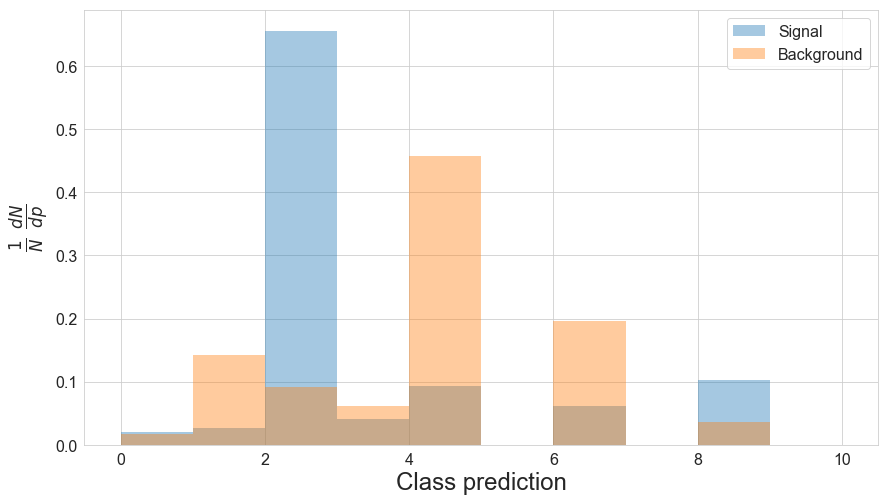

In [21]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [22]:
bin_preds(df)

In [23]:
df.head()

,pred,gen_target,pred_bin
0,2,1.0,2
1,0,1.0,0
2,1,1.0,1
3,2,1.0,2
4,2,1.0,2


In [24]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [25]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [26]:
f_s, f_b

(tensor([1.9598e-02, 2.6886e-02, 6.5617e-01, 4.0610e-02, 9.2610e-02, 2.0000e-13,
         6.1056e-02, 2.0000e-13, 1.0307e-01, 2.0000e-13]),
 tensor([1.6518e-02, 1.4166e-01, 9.1888e-02, 6.1986e-02, 4.5695e-01, 2.0000e-13,
         1.9562e-01, 2.0000e-13, 3.5378e-02, 2.0000e-13]))

In [27]:
asimov = (50*f_s)+(1000*f_b)

In [28]:
asimov, asimov.sum()

(tensor([1.7498e+01, 1.4300e+02, 1.2470e+02, 6.4017e+01, 4.6158e+02, 2.1000e-10,
         1.9867e+02, 2.1000e-10, 4.0532e+01, 2.1000e-10]), tensor(1050.))

In [29]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([24.31669998, 24.18473053, 24.05853653, 23.93710709, 23.82071304,
       23.70946121, 23.60367203, 23.50209427, 23.40593338, 23.31440735,
       23.22730637, 23.14532852, 23.06740952, 22.99457932, 22.92600632,
       22.86242676, 22.80303574, 22.74787903, 22.69713974, 22.65055466,
       22.60863876, 22.57040405, 22.53687668, 22.50691986, 22.48178482,
       22.46001053, 22.44260025, 22.42920303, 22.419384  , 22.41371918,
       22.4119072 , 22.4135437 , 22.41888809, 22.42887115, 22.44161606,
       22.4583931 , 22.47896194, 22.50282669, 22.53014755, 22.56137085,
       22.59592819, 22.63393402, 22.67530441, 22.71986771, 22.76807022,
       22.81973267, 22.87420273, 22.93247604, 22.99393082, 23.05833817,
       23.12582016, 23.19669342, 23.27047348, 23.34776688, 23.42807388,
       23.51110077, 23.59698868, 23.68638992, 23.77823257, 23.87355423,
       23.97180557])

In [30]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [31]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

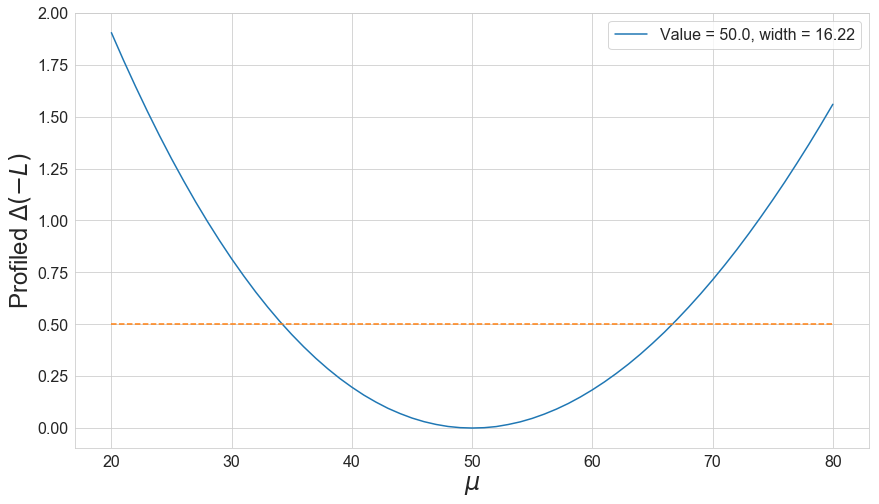

In [32]:
plot_likelihood(y-y.min())

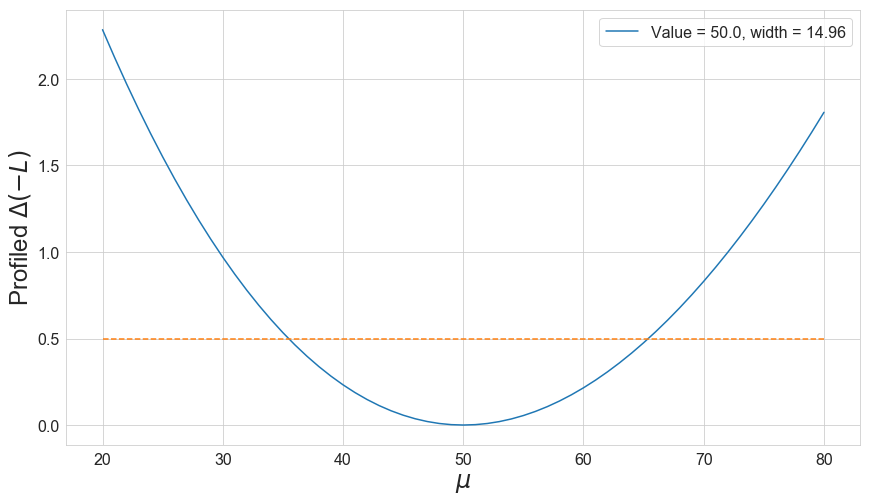

In [33]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [34]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [35]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [36]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,2,1.0,2,2,2,2,2,2,2,2,2,2,2
1,0,1.0,0,0,0,0,0,0,0,0,0,0,0
2,1,1.0,1,1,1,1,1,1,1,1,1,1,1
3,2,1.0,2,2,2,2,2,2,2,2,2,2,2
4,2,1.0,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,6,0.0,6,6,6,6,6,6,6,6,6,6,6
999996,4,0.0,4,4,4,4,4,4,4,4,4,4,4
999997,2,0.0,2,2,2,2,2,2,2,2,2,2,2
999998,4,0.0,4,4,4,4,4,4,4,4,4,4,4


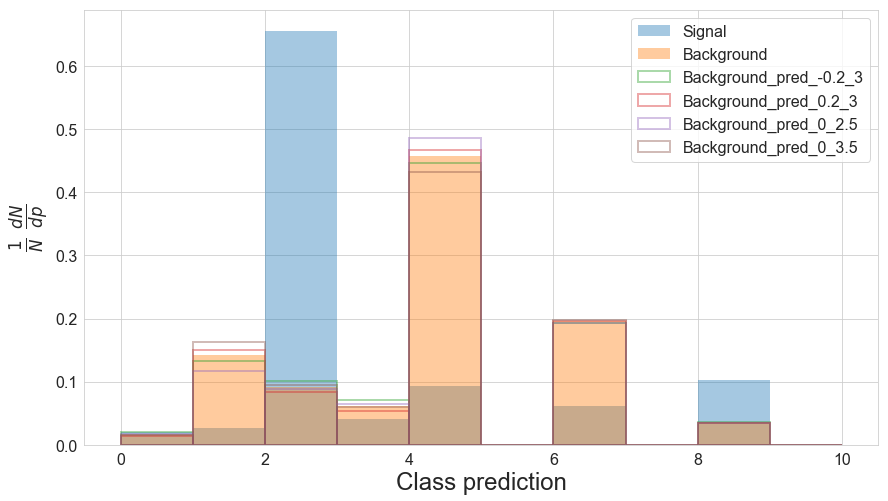

In [37]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([2.0400e-02, 1.0704e-01, 9.7454e-02, 7.2776e-02, 4.7628e-01, 2.0000e-13,
        1.9001e-01, 2.0000e-13, 3.6044e-02, 2.0000e-13])
tensor([1.9910e-02, 1.3241e-01, 1.0036e-01, 7.0896e-02, 4.4681e-01, 2.0000e-13,
        1.9330e-01, 2.0000e-13, 3.6314e-02, 2.0000e-13])
tensor([1.9394e-02, 1.5392e-01, 1.0358e-01, 6.9200e-02, 4.2241e-01, 2.0000e-13,
        1.9531e-01, 2.0000e-13, 3.6188e-02, 2.0000e-13])
tensor([1.7008e-02, 1.1628e-01, 8.8980e-02, 6.3866e-02, 4.8642e-01, 2.0000e-13,
        1.9233e-01, 2.0000e-13, 3.5108e-02, 2.0000e-13])
tensor([1.6518e-02, 1.4166e-01, 9.1888e-02, 6.1986e-02, 4.5695e-01, 2.0000e-13,
        1.9562e-01, 2.0000e-13, 3.5378e-02, 2.0000e-13])
tensor([1.6002e-02, 1.6317e-01, 9.5102e-02, 6.0290e-02, 4.3255e-01, 2.0000e-13,
        1.9763e-01, 2.0000e-13, 3.5252e-02, 2.0000e-13])
tensor([1.4234e-02, 1.2528e-01, 8.0470e-02, 5.5800e-02, 4.9684e-01, 2.0000e-13,
        1.9350e-01, 2.0000e-13, 3.3880e-02, 2.0000e-13])
tensor([1.3744e-02, 1.5065e-01, 8.3378e-0

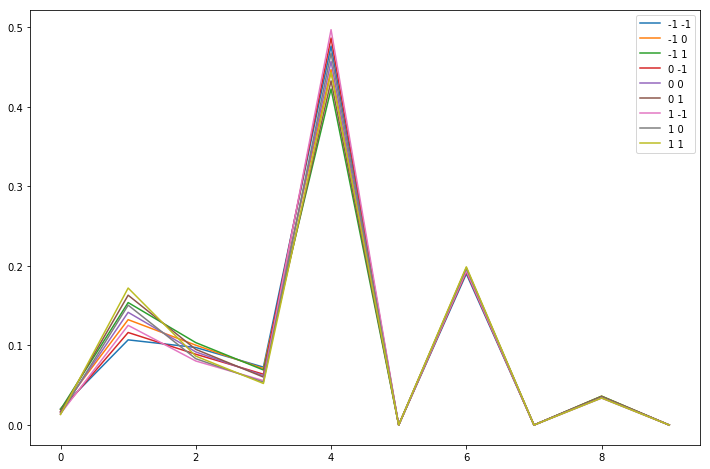

In [38]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [39]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [40]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [41]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [42]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [43]:
nll = to_np(nll)

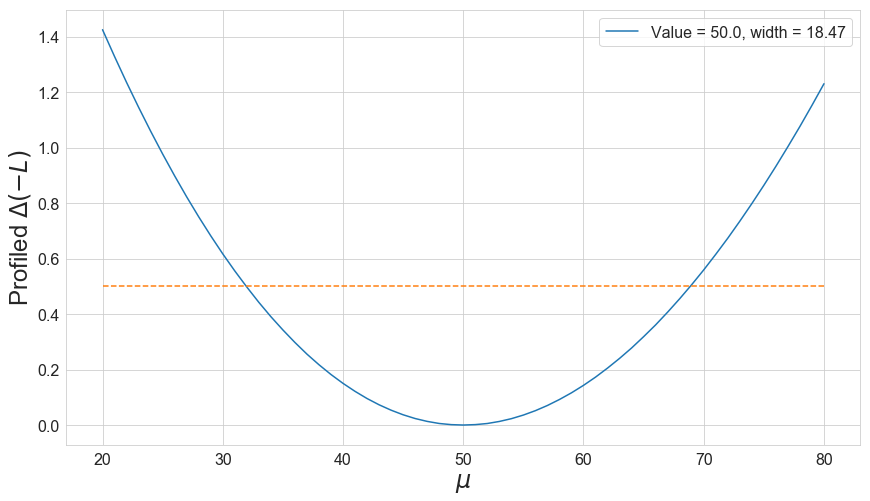

In [44]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [45]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [46]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [47]:
nll = to_np(nll)

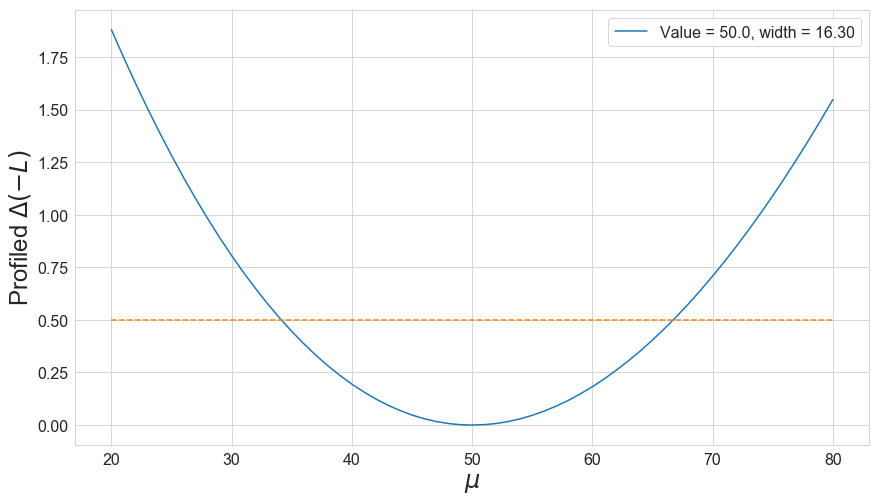

In [48]:
plot_likelihood(nll-nll.min())

## BM 2

In [49]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [50]:
nll = to_np(nll)

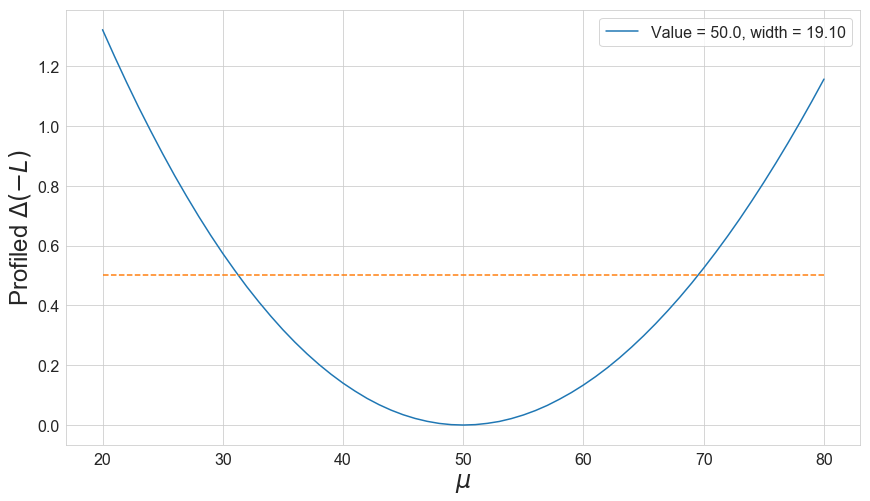

In [51]:
plot_likelihood(nll-nll.min())